<a href="https://colab.research.google.com/github/kat-le/cmpe255-assignment4/blob/main/kdd_movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MovieLens Recommenders with KDD

**What we’ll do**
* Use MovieLens (ratings + movies + tags + links) to build a small recommender.

* Follow KDD: clean → integrate tables → select the right subset → transform into matrices/features → mine patterns via Collaborative Filtering (SVD) and Association Rules → evaluate with RMSE + HitRate@K → present insights & sample recommendations.

**Business-style goals**
* Recommend good movies to users; surface robust “people who liked X also liked Y” patterns.
* Success = lower RMSE on held-out ratings, higher HitRate@K (did we place the held-out movie in the user’s top-K?).

**Overview:**
* Cleaning: bogus timestamps/tags.
* Integration: join ratings with movie metadata; optional TMDB merge.
* Selection/Transformation: user/movie embeddings or pivots.
* Data Mining: Collaborative filtering (ALS/SVD), clustering.
* Evaluation: RMSE on held-out ratings; Precision@K.
* Presentation: recommendation lists; genre heatmaps.

In [1]:
!pip -q install scikit-surprise mlxtend

In [2]:
!pip uninstall -y numpy
!pip install 'numpy<2'

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-cont

In [6]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, math, random
from IPython.display import display

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as sp_train_test_split
from surprise import accuracy as sp_accuracy

from mlxtend.frequent_patterns import apriori, association_rules

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
RNG_SEED = 42
def set_seed(s=RNG_SEED):
    np.random.seed(s); random.seed(s)

def ok(msg="OK"):
    print(f"✅ {msg}")

def expect(cond, msg="Check failed"):
    assert bool(cond), f"❌ {msg}"
    return True

set_seed()
ok("Environment ready")

✅ Environment ready


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [8]:
ratings_path = "ratings.csv"
movies_path  = "movies.csv"
tags_path    = "tags.csv"
links_path   = "links.csv"

ratings = pd.read_csv(ratings_path)
movies  = pd.read_csv(movies_path)
tags    = pd.read_csv(tags_path)
links   = pd.read_csv(links_path)

if "timestamp" in ratings.columns:
    ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s", errors="coerce")
if "timestamp" in tags.columns:
    tags["timestamp"] = pd.to_datetime(tags["timestamp"], unit="s", errors="coerce")

In [9]:
print(ratings.shape, movies.shape, tags.shape, links.shape)
display(ratings.head(), movies.head(), tags.head(), links.head())

(100836, 4) (9742, 3) (3683, 4) (9742, 3)


,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,2,60756,funny,2015-10-24 19:29:54
1,2,60756,Highly quotable,2015-10-24 19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52
3,2,89774,Boxing story,2015-10-24 19:33:27
4,2,89774,MMA,2015-10-24 19:33:20


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Data Cleaning

* Drop impossible ratings (outside 0.5–5.0), duplicates, empty titles/genres.
* Normalize genres to a clean list; trim whitespace.
* De-duplicate identical (userId, movieId, timestamp) rows if any.

In [10]:
# Ratings range & duplicates
before = len(ratings)
ratings = ratings[ratings["rating"].between(0.5, 5.0)]
ratings = ratings.drop_duplicates(subset=["userId","movieId","timestamp"], keep="last")
after = len(ratings)
print(f"Filtered ratings: {before} → {after}")

Filtered ratings: 100836 → 100836


In [11]:
# Clean movie titles/genres
movies["title"]  = movies["title"].astype(str).str.strip()
movies["genres"] = movies["genres"].astype(str).str.strip().replace({"(no genres listed)":"Unknown"}, regex=False)

# Basic NA removes
movies = movies.dropna(subset=["title","genres"])
ratings = ratings.dropna(subset=["userId","movieId","rating"])

In [12]:
if not tags.empty:
    tags["tag"] = tags["tag"].astype(str).str.strip()
    tags = tags[tags["tag"].str.len() > 0].drop_duplicates()

## Data Integration

* Join ratings and movies to get titles/genres alongside ratings.
* Aggregate tags per movie and merge.

In [13]:
# Merge ratings with movies
rat_mov = ratings.merge(movies, on="movieId", how="inner")

# Aggregate tags per movie
if not tags.empty:
    movie_tags = tags.groupby("movieId")["tag"].apply(lambda s: list(pd.unique(s))).reset_index()
    rat_mov = rat_mov.merge(movie_tags, on="movieId", how="left")
else:
    rat_mov["tag"] = np.nan

In [14]:
display(rat_mov.head())

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[pixar, fun]"
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,"[moldy, old]"
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,NaN
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"[mystery, twist ending, serial killer]"
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"[mindfuck, suspense, thriller, tricky, twist e..."


## Data Selection

* Reduce sparsity by filtering to active users and popular movies (configurable thresholds).
* Keep enough data for meaningful training/evaluation.

In [15]:
MIN_USER_RATINGS = 20
MIN_MOVIE_RATINGS = 20

def filter_by_min_counts(df, user_col="userId", item_col="movieId", min_uc=20, min_ic=20):
    last_len = -1
    cur = df.copy()
    while last_len != len(cur):
        last_len = len(cur)
        user_counts = cur[user_col].value_counts()
        item_counts = cur[item_col].value_counts()
        cur = cur[cur[user_col].isin(user_counts[user_counts >= min_uc].index)]
        cur = cur[cur[item_col].isin(item_counts[item_counts >= min_ic].index)]
    return cur

In [16]:
rat_sel = filter_by_min_counts(rat_mov, min_uc=MIN_USER_RATINGS, min_ic=MIN_MOVIE_RATINGS)
print("Selected ratings:", rat_sel.shape, "| unique users:", rat_sel.userId.nunique(), "| unique movies:", rat_sel.movieId.nunique())

Selected ratings: (67020, 7) | unique users: 566 | unique movies: 1286


In [17]:
expect(rat_sel.userId.nunique()>0 and rat_sel.movieId.nunique()>0, "Selection too aggressive")
ok("Data selection done")

✅ Data selection done


## Data Transformation

* Split by time: for each user, keep their last rating as test (leave-one-out); rest is train.
* Encode genres into a multi-hot matrix for later analysis; build popularity list for candidate generation.

In [18]:
# Leave-one-out split per user (latest timestamp to test)
rat_sel = rat_sel.sort_values(["userId","timestamp"])
idx_last = rat_sel.groupby("userId")["timestamp"].idxmax()
test_df = rat_sel.loc[idx_last]
train_df = rat_sel.drop(index=idx_last)

print("Train size:", train_df.shape, "Test size:", test_df.shape)

Train size: (66454, 7) Test size: (566, 7)


In [19]:
# Multi-hot genres for later plots
all_genres = sorted({g for row in movies["genres"].dropna().astype(str) for g in row.split("|")})
def genre_multi_hot(genres_str):
    genres = set(genres_str.split("|")) if isinstance(genres_str, str) else set()
    return pd.Series([int(g in genres) for g in all_genres], index=all_genres)

In [20]:
movie_genres = movies.set_index("movieId")["genres"].apply(genre_multi_hot)
movie_genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# Popularity (for candidate pools)
pop_movies = train_df["movieId"].value_counts().index.tolist()

 ## Data Mining — Collaborative Filtering (SVD)

* Train a Surprise SVD model on train ratings (explicit feedback).
* Predict the held-out rating for each user (their “last” item) for RMSE.

In [46]:
# Prepare Surprise dataset
reader = Reader(rating_scale=(0.5, 5.0))
train_surp = Dataset.load_from_df(train_df[["userId","movieId","rating"]], reader).build_full_trainset()

# Train SVD (you can tune n_factors, reg, lr_all, n_epochs)
set_seed()
svd = SVD(
    n_factors=100,    # latent dims
    n_epochs=40,      # training passes
    lr_all=0.006,     # learning rate
    reg_all=0.08,     # regularization
    biased=True,
    random_state=42
)
svd.fit(train_surp)

# Predict on leave-one-out items
preds = []
for r in test_df.itertuples(index=False):
    pred = svd.predict(int(r.userId), int(r.movieId), r.rating)
    preds.append(pred.est)

In [47]:
rmse = math.sqrt(((test_df["rating"].values - np.array(preds))**2).mean())
mae  = np.abs(test_df["rating"].values - np.array(preds)).mean()
print(f"SVD — LOO Test: RMSE={rmse:.4f}, MAE={mae:.4f}")

SVD — LOO Test: RMSE=0.9098, MAE=0.6934


## Pattern Evaluation — Top-K ranking (HitRate@K, Recall@K)

* For each user, rank candidate movies (not seen in train).

* Check if the held-out movie appears in the Top-K list → HitRate@K (same as Recall@K with one held-out item).

In [48]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

LIKE_THRESHOLD = 4.0
MIN_SUPPORT    = 0.03
MAX_LEN        = 2
liked = train_df[train_df["rating"] >= LIKE_THRESHOLD][["userId","movieId"]].drop_duplicates()

basket = (liked.assign(val=1)
                .pivot_table(index="userId", columns="movieId",
                             values="val", aggfunc="max", fill_value=0)
                .astype("bool"))

freq = fpgrowth(basket, min_support=MIN_SUPPORT, use_colnames=True, max_len=MAX_LEN)

rules = association_rules(freq, metric="lift", min_threshold=1.05)
rules = rules.sort_values(["lift","confidence","support"], ascending=False)

print(freq.shape, "frequent itemsets")
print(rules.shape, "rules")
display(rules.head(10))



(17012, 2) frequent itemsets
(32230, 14) rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
21068,(3681),(2951),0.042403,0.051237,0.031802,0.750000,14.637931,1.0,0.029630,3.795053,0.972940,0.514286,0.736499,0.685345
21069,(2951),(3681),0.051237,0.042403,0.031802,0.620690,14.637931,1.0,0.029630,2.524574,0.981999,0.514286,0.603894,0.685345
19976,(745),(1223),0.058304,0.040636,0.031802,0.545455,13.422925,1.0,0.029433,2.110601,0.982802,0.473684,0.526201,0.664032
19977,(1223),(745),0.040636,0.058304,0.031802,0.782609,13.422925,1.0,0.029433,4.331802,0.964702,0.473684,0.769149,0.664032
31991,(88125),(81834),0.056537,0.054770,0.038869,0.687500,12.552419,1.0,0.035773,3.024735,0.975485,0.536585,0.669393,0.698589
31990,(81834),(88125),0.054770,0.056537,0.038869,0.709677,12.552419,1.0,0.035773,3.249706,0.973662,0.536585,0.692280,0.698589
25466,(1376),(1374),0.037102,0.068905,0.031802,0.857143,12.439560,1.0,0.029246,6.517668,0.955046,0.428571,0.846571,0.659341
25467,(1374),(1376),0.068905,0.037102,0.031802,0.461538,12.439560,1.0,0.029246,1.788238,0.987666,0.428571,0.440790,0.659341
31988,(81834),(69844),0.054770,0.065371,0.044170,0.806452,12.336530,1.0,0.040589,4.828916,0.972187,0.581395,0.792914,0.741064
31989,(69844),(81834),0.065371,0.054770,0.044170,0.675676,12.336530,1.0,0.040589,2.914458,0.983214,0.581395,0.656883,0.741064


## Data Mining (2) — Association Rules (market-basket style)

* Build baskets of liked movies per user (e.g., rating ≥ 4.0).
* Mine frequent itemsets (Apriori) and extract rules with lift.

In [49]:
# Map movieId -> title
movie_title = movies.set_index("movieId")["title"].to_dict()

def ids_to_titles(itemset):
    # itemset is a frozenset of movieIds
    return " + ".join(movie_title.get(int(mid), str(mid)) for mid in itemset)

# n_users is the number of baskets (users) used in fpgrowth step
n_users = basket.shape[0]

rules_en = rules.copy()
rules_en["antecedent_titles"] = rules_en["antecedents"].apply(ids_to_titles)
rules_en["consequent_titles"] = rules_en["consequents"].apply(ids_to_titles)
rules_en["co_users"] = (rules_en["support"] * n_users).round().astype(int)

# Keep only meaningful pair rules (since max_len=2 they should be pairs)
MIN_CONF = 0.20
MIN_LIFT = 1.05
rules_en = rules_en[(rules_en["confidence"] >= MIN_CONF) & (rules_en["lift"] >= MIN_LIFT)]

# Order for readability
rules_en = rules_en.sort_values(["lift","confidence","support"], ascending=False)

print("Rules after filtering:", rules_en.shape)
display(rules_en[["antecedent_titles","consequent_titles","co_users","support","confidence","lift"]].head(15))

ok("Rules post-processed and filtered")


Rules after filtering: (25092, 17)


,antecedent_titles,consequent_titles,co_users,support,confidence,lift
21068,For a Few Dollars More (Per qualche dollaro in...,"Fistful of Dollars, A (Per un pugno di dollari...",18,0.031802,0.750000,14.637931
21069,"Fistful of Dollars, A (Per un pugno di dollari...",For a Few Dollars More (Per qualche dollaro in...,18,0.031802,0.620690,14.637931
19976,Wallace & Gromit: A Close Shave (1995),"Grand Day Out with Wallace and Gromit, A (1989)",18,0.031802,0.545455,13.422925
19977,"Grand Day Out with Wallace and Gromit, A (1989)",Wallace & Gromit: A Close Shave (1995),18,0.031802,0.782609,13.422925
31991,Harry Potter and the Deathly Hallows: Part 2 (...,Harry Potter and the Deathly Hallows: Part 1 (...,22,0.038869,0.687500,12.552419
31990,Harry Potter and the Deathly Hallows: Part 1 (...,Harry Potter and the Deathly Hallows: Part 2 (...,22,0.038869,0.709677,12.552419
25466,Star Trek IV: The Voyage Home (1986),Star Trek II: The Wrath of Khan (1982),18,0.031802,0.857143,12.439560
25467,Star Trek II: The Wrath of Khan (1982),Star Trek IV: The Voyage Home (1986),18,0.031802,0.461538,12.439560
31988,Harry Potter and the Deathly Hallows: Part 1 (...,Harry Potter and the Half-Blood Prince (2009),25,0.044170,0.806452,12.336530
31989,Harry Potter and the Half-Blood Prince (2009),Harry Potter and the Deathly Hallows: Part 1 (...,25,0.044170,0.675676,12.336530


✅ Rules post-processed and filtered


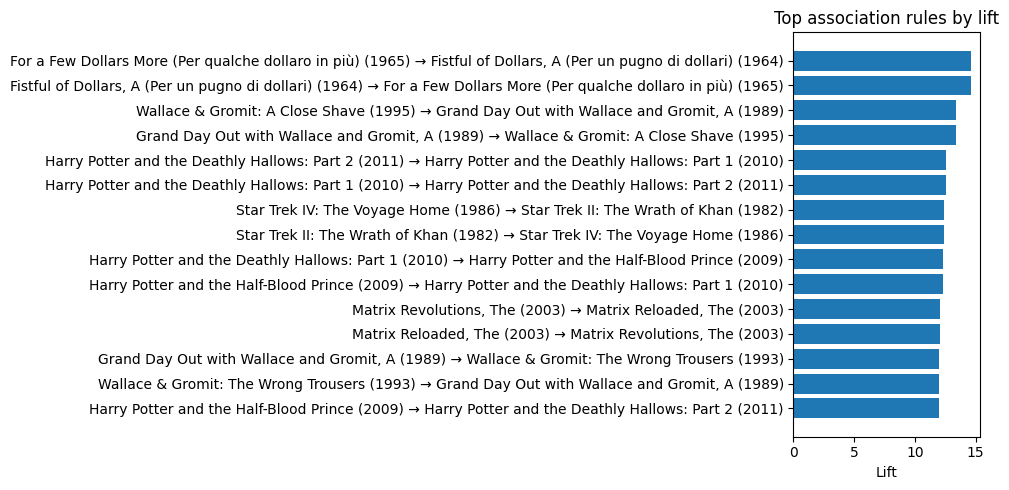

✅ Top rules plotted


In [50]:
topN = 15
top_rules = rules_en.head(topN).copy()
labels = (top_rules["antecedent_titles"] + " → " + top_rules["consequent_titles"]).tolist()

plt.figure(figsize=(10,5))
plt.barh(range(len(top_rules)), top_rules["lift"].values)
plt.yticks(range(len(top_rules)), labels)
plt.gca().invert_yaxis()
plt.title("Top association rules by lift")
plt.xlabel("Lift")
plt.tight_layout()
plt.show()

ok("Top rules plotted")


In [51]:
# Pick a demo user (or set demo_user = <some userId>)
demo_user = int(train_df["userId"].sample(1, random_state=42).iloc[0])

# User's liked movies (train only)
LIKE_THRESHOLD = 4.0
user_likes = set(train_df[(train_df["userId"]==demo_user) & (train_df["rating"]>=LIKE_THRESHOLD)]["movieId"].unique())

# Keep pair rules where antecedent is a single item the user liked
def antecedent_single_mid(ant):
    # Return the single movieId if antecedent is size 1; else None
    if len(ant) == 1:
        return list(ant)[0]
    return None

candidates = []
for r in rules_en.itertuples(index=False):
    a_mid = antecedent_single_mid(r.antecedents)
    c_mid = antecedent_single_mid(r.consequents)
    if a_mid is None or c_mid is None:
        continue
    if int(a_mid) in user_likes and int(c_mid) not in user_likes:
        candidates.append({
            "because_you_liked": movie_title.get(int(a_mid), a_mid),
            "try": movie_title.get(int(c_mid), c_mid),
            "confidence": float(r.confidence),
            "lift": float(r.lift),
            "co_users": int(r.co_users)
        })

rules_recs = (pd.DataFrame(candidates)
                .sort_values(["lift","confidence","co_users"], ascending=False)
                .drop_duplicates(subset=["try"])
                .head(10))

print(f"User {demo_user} — rule-based 'also liked' suggestions:")
display(rules_recs)

ok("Rule-based suggestions generated")

User 21 — rule-based 'also liked' suggestions:


,because_you_liked,try,confidence,lift,co_users
0,Harry Potter and the Deathly Hallows: Part 2 (...,Harry Potter and the Deathly Hallows: Part 1 (...,0.687500,12.552419,22
2,"Matrix Revolutions, The (2003)","Matrix Reloaded, The (2003)",0.769231,12.094017,20
3,Harry Potter and the Deathly Hallows: Part 2 (...,Harry Potter and the Order of the Phoenix (2007),0.625000,10.404412,20
7,Iron Man (2008),X-Men: First Class (2011),0.333333,7.861111,18
8,Planet of the Apes (1968),Rocky (1976),0.558824,7.530812,19
10,Star Wars: Episode III - Revenge of the Sith (...,300 (2007),0.461538,7.256410,18
12,Casino Royale (2006),"Hurt Locker, The (2008)",0.333333,6.987654,17
13,Star Wars: Episode III - Revenge of the Sith (...,Spider-Man 2 (2004),0.487179,6.725453,19
14,Harry Potter and the Prisoner of Azkaban (2004),"Chronicles of Narnia: The Lion, the Witch and ...",0.288136,6.523390,17
16,Iron Man (2008),Watchmen (2009),0.314815,6.363757,17


✅ Rule-based suggestions generated


In [52]:
K = 10

# Build seen set from train (if not already)
seen_by_user = train_df.groupby("userId")["movieId"].apply(set).to_dict()
pop_movies = train_df["movieId"].value_counts().index.tolist()  # if not defined earlier

def svd_topk_titles_for_user(u, K=10, candidates_pop=500):
    seen = seen_by_user.get(u, set())
    cand = [m for m in pop_movies if m not in seen][:candidates_pop]
    scores = [(m, svd.predict(int(u), int(m)).est) for m in cand]
    best = sorted(scores, key=lambda x: x[1], reverse=True)[:K]
    return [(movie_title.get(int(m), m), s) for m,s in best]

svd_recs = svd_topk_titles_for_user(demo_user, K=10)
print(f"User {demo_user} — SVD Top-{K}:")
for title, score in svd_recs:
    print(f"  {title:60s}  (pred={score:.2f})")

ok("SVD recommendations listed")

User 21 — SVD Top-10:
  Remember the Titans (2000)                                    (pred=4.03)
  Whiplash (2014)                                               (pred=3.94)
  Go (1999)                                                     (pred=3.93)
  Shawshank Redemption, The (1994)                              (pred=3.93)
  Princess Bride, The (1987)                                    (pred=3.92)
  Contact (1997)                                                (pred=3.90)
  American History X (1998)                                     (pred=3.87)
  Fugitive, The (1993)                                          (pred=3.86)
  Sound of Music, The (1965)                                    (pred=3.86)
  Green Mile, The (1999)                                        (pred=3.85)
✅ SVD recommendations listed


In [53]:
# === HitRate@K (Recall@K with one held-out item) ===
K = 10
ALL_UNSEEN = False      # True = use ALL unseen items (slower); False = popular subset
CANDIDATES_POP = 500    # only used when ALL_UNSEEN=False

hits = hits_pop = tot = with_pool = 0
all_items = movies["movieId"].unique().tolist()

for row in test_df.itertuples(index=False):
    u, true_item = int(row.userId), int(row.movieId)
    seen = seen_by_user.get(u, set())

    if ALL_UNSEEN:
        cand = [int(m) for m in all_items if m not in seen]
    else:
        cand = [int(m) for m in pop_movies if m not in seen][:CANDIDATES_POP]

    if not cand:
        continue

    with_pool += int(len(cand) >= K)

    # Score candidates with SVD
    scores = [(m, svd.predict(u, int(m)).est) for m in cand]
    topk   = [m for m,_ in sorted(scores, key=lambda x: x[1], reverse=True)[:K]]

    hits     += int(true_item in topk)     # model hit
    hits_pop += int(true_item in cand[:K]) # popularity baseline hit
    tot      += 1

print(f"Users evaluated: {tot}")
print(f"HitRate@{K} (SVD):        {hits/tot:.3f}")
print(f"HitRate@{K} (Popularity): {hits_pop/tot:.3f}")
print(f"Candidate coverage ≥{K}:  {with_pool/tot:.0%}")

Users evaluated: 566
HitRate@10 (SVD):        0.051
HitRate@10 (Popularity): 0.049
Candidate coverage ≥10:  100%


In [41]:
out_rules = rules_en.head(200)[["antecedent_titles","consequent_titles","co_users","support","confidence","lift"]]
out_rules.to_csv("association_rules_top200.csv", index=False)

rules_recs.to_csv(f"rule_based_recs_user_{demo_user}.csv", index=False)

print("Saved:", os.path.abspath("association_rules_top200.csv"))
print("Saved:", os.path.abspath(f"rule_based_recs_user_{demo_user}.csv"))
ok("Artifacts saved")

Saved: /content/association_rules_top200.csv
Saved: /content/rule_based_recs_user_21.csv
✅ Artifacts saved
